In [205]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import math
import cv2
import sys
from scipy import io


def ASTM_E399(Pq,a,B,W):
    """B is thickness(cm), W is width(cm), Pq is stress(kN), A is crack length(cm)"""
    f_in = a/W
    f=((2+f_in)*(0.886+4.64*f_in-13.32*(f_in**2)+14.72*(f_in**3)-5.6*(f_in**4)))/((1-f_in)**1.5)
    kq=(Pq*f)/(B*(W**0.5)*1000000)
    return kq

def hookes_law_sigmayy(YoungsModulus, Poisson, strain_xx, strain_yy):
    sigma_yy = YoungsModulus*(strain_xx*Poisson + strain_yy)/(1-Poisson**2)
    return sigma_yy

def Williams_sigmayy(r, theta):
    theta = math.radians(theta)
    K1_coefficient = np.cos(theta/2) * (1 + np.sin(theta/2) * np.sin(3 * theta / 2)) / (2 * np.pi * r) ** 0.5
    K2_coefficient = np.sin(theta/2) * np.cos(theta/2) * np.cos(3*theta/2) / (2 * np.pi * r) ** 0.5
    return [K1_coefficient, K2_coefficient]

def make_mask(path, num):
    class PolygonDrawer(object):
        def __init__(self, window_name):
            self.window_name = window_name # Name for our window
            self.done = False # Flag signalling we're done
            self.current = (0, 0) # Current position, so we can draw the line-in-progress
            self.points = [] # List of points defining our polygon

        def on_mouse(self, event, x, y, buttons, user_param):
            # Mouse callback that gets called for every mouse event (i.e. moving, clicking, etc.)
            if self.done: # Nothing more to do
                return
            if event == cv2.EVENT_MOUSEMOVE:
                # We want to be able to draw the line-in-progress, so update current mouse position
                self.current = (x, y)
            elif event == cv2.EVENT_LBUTTONDOWN:
                # Left click means adding a point at current position to the list of points
                # print("Adding point #%d with position(%d,%d)" % (len(self.points), x, y))
                self.points.append((x, y))
            elif event == cv2.EVENT_RBUTTONDOWN:
                # Right click means we're done
                print("Completing polygon with %d points." % len(self.points))
                self.done = True


        def run(self):
            # Let's create our working window and set a mouse callback to handle events
            cv2.namedWindow(self.window_name)
            cv2.imshow(self.window_name, np.zeros(CANVAS_SIZE, np.uint8))
            cv2.waitKey(1)
            cv2.setMouseCallback(self.window_name, self.on_mouse)

            while(not self.done):
                # This is our drawing loop, we just continuously draw new images
                # and show them in the named window
                canvas = image
                if (len(self.points) > 0):
                    # Draw all the current polygon segments
                    cv2.polylines(canvas, np.array([self.points]), False, (255, 255, 255), 1)
                    # And  also show what the current segment would look like
                    # cv2.line(canvas, self.points[-1], self.current, WORKING_LINE_COLOR)
                # Update the window
                cv2.imshow(self.window_name, canvas)
                # And wait 50ms before next iteration (this will pump window messages meanwhile)
                if cv2.waitKey(50) == 27: # ESC hit
                    self.done = True

            # User finised entering the polygon points, so let's make the final drawing
            canvas = image
            # of a filled polygon
            if (len(self.points) > 0):
                cv2.fillPoly(canvas, np.array([self.points]), (255, 255, 255))
                # print(np.array([self.points]))

            # And show it
            cv2.imshow(self.window_name, canvas)
            # Waiting for the user to press any key
            cv2.waitKey()
            cv2.destroyWindow(self.window_name)

            return canvas, self.points

    file_list = os.listdir(path)
    img = [file for file in file_list if file.endswith(".jpg")]
    image = cv2.imread(path+'/'+img[num], cv2.IMREAD_GRAYSCALE)

    if image is None:
        print('Image load failed!')
        sys.exit()
    x, y, w, h = cv2.selectROI(image)
    cv2.destroyAllWindows()

    cv2.rectangle(image, (x,y), (x+w,y+h),(0,0,0),2)
    CANVAS_SIZE = np.shape(image)

    poly = PolygonDrawer("Polygon")
    _, poly_points = poly.run()

    ##mask part
    mask = np.zeros(np.shape(image))
    mask[y:y+h, x:x+w] = 255
    cv2.fillPoly(mask, np.array([poly_points]), (0,0,0))
    cv2.imshow('mask', mask)

    #%% save part
    cv2.imwrite(path+'/'+str(num)+'.png',mask)
    cv2.waitKey()
    cv2.destroyAllWindows()

    return x, y ,w ,h


In [87]:
"""
step1. make mask reference, current

"""



path = r'E:\experiment data\aluminum\2021-01-27\0.05mmsec_125f_epoxy_dic\dic'
ref_xywh = make_mask(path, 0)
cur_xywh = make_mask(path, 8) #path, image number in foloder

(79, 59)


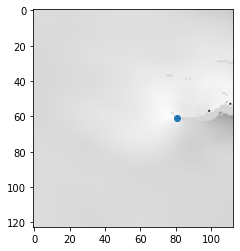

array([[ 88.72946865],
       [-55.01518115]])

In [311]:
from scipy import io
import matplotlib.pyplot as plt
"""

#mat save code
exx = handles_ncorr.data_dic.strains.plot_exx_cur_formatted
eyy = handles_ncorr.data_dic.strains.plot_eyy_cur_formatted
roi_cur = handles_ncorr.data_dic.strains.roi_cur_formatted
"""


mat_path = 'E:\experiment data/aluminum/2021-01-27/0.05mmsec_125f_epoxy_dic/dic_mat/'
exx = io.loadmat(mat_path+'num8_exx.mat')['exx'][145:268, 20:133]
eyy = io.loadmat(mat_path+'num8_eyy.mat')['eyy'][145:268, 20:133]
crack= (79,59) # x, y
print(crack)
num = []
for _ in range(20):
    i = np.random.randint(0,60) #x
    j = np.random.randint(0,123) #y
    num.append([i,j])

plt.imshow(eyy, cmap='gray')
plt.scatter(81,61, cmap='red' )
plt.show()

from scipy.spatial import distance

length = []
for a in num:
    lengthg = distance.cdist([crack], [a]) * 0.0303030303
    length.append(lengthg)


mir = num.copy()

mir_ = []
for i in range(20):
    y_ = mir[i][1]-crack[1]
    x_ = (mir[i][0]-crack[0])*-1
    mir_.append([x_,y_])

mir_
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    degree = math.degrees(phi)
    return(rho, degree)
theta = []
r  = []
for i in range(20):
    theta.append(cart2pol(mir_[i][0], mir_[i][1])[1])
    r.append(cart2pol(mir_[i][0], mir_[i][1])[0]*0.030303030)

theta
r

wil = []
for a, b in zip(r, theta):
    wil.append(Williams_sigmayy(a*0.001, b))
wil

num #x, y_
exxxx = []
eyyyy = []

for c,d in num:
    exxxx.append(exx[d, c])
    eyyyy.append(eyy[d, c])

tot = []
for e,f in zip(exxxx,eyyyy,):
    tot.append(hookes_law_sigmayy(71700,0.33,e,f))
tot

tott = np.reshape(tot,[-1,1])
KKKK = np.dot(np.linalg.inv(np.dot(np.transpose(wil),wil)),np.dot(np.transpose(wil),tott))
KKKK

In [125]:
def ASTM_E399(Pq,a,B,W):
    """B is thickness, W is width, Pq is stress, A is crack length"""

    f_in = a/W
    f=((2+f_in)*(0.886+4.64*f_in-13.32*(f_in**2)+14.72*(f_in**3)-5.6*(f_in**4)))/((1-f_in)**1.5)
    kq=(Pq*f)/(B*(W**0.5))
    return kq
ASTM_E399(0.275269*3000,0.00938601+0.015, 0.003,0.04)
#0.275269 *3000  ,0.9386010+1.5,3,4)


19527375.633127358

In [124]:
import pandas as pd
from scipy.spatial import distance
import numpy as np
import math
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    degree = math.degrees(phi)
    return(rho, degree)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

class Crack_tip():
    def __init__(self, ratio):
        """ x, y 는 좌표, point 는 리스트로 x,y좌표 모아줌, count는 좌표 몇개, 길이, 1픽셀당 mm(mm/1픽셀)"""
        self.x = 0
        self.y =0
        self.point = []
        self.count= -1
        self.length = 0
        self.ratio = ratio
        self.df = pd.DataFrame(index = range(0,3), columns=['index', 'length',  'length(add)', 'x', 'y'])
        return print("Enter initial position")

    def inital(self, x, y):
        self.x = x
        self.y= y
        self.point.append([[x,y]])
        self.df.loc[0] = [self.count+1, 0 , 0 , x, y]
        self.count +=1


    def append(self, x, y):
        self.x =x
        self.y= y
        self.point.append([[x,y]])
        self.count +=1
        self.length = distance.cdist(self.point[self.count-1], self.point[self.count]) * self.ratio
        self.df.loc[self.count] = [self.count, self.length ,self.length + self.df["length(add)"][self.count-1], x, y]


    def position(self):
        return self.point

    def all_position(self):
        return self.df
    pass
crack_tip=Crack_tip(0.03030303)
crack_tip.inital(503,374)
crack_tip.append(503,374)
crack_tip.append(503,374)
crack_tip.append(503,374)
crack_tip.append(503,374)
crack_tip.append(503,374)
crack_tip.append(422,378)
crack_tip.append(202,410)
crack_tip.append(196,408)
crack_tip.all_position()

#cart2pol(3, 3)
# YoungsModulus =
# Poisson =


Enter initial position


C:\Users\ghrms\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:983: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr_value = np.array(value)


,index,length,length(add),x,y
0,0,0,0,503,374
1,1,[[0.0]],[[0.0]],503,374
2,2,[[0.0]],[[0.0]],503,374
3,3,[[0.0]],[[0.0]],503,374
4,4,[[0.0]],[[0.0]],503,374
5,5,[[0.0]],[[0.0]],503,374
6,6,[[2.4575364994174103]],[[2.4575364994174103]],422,378
7,7,[[6.736820893402823]],[[9.194357392820233]],202,410
8,8,[[0.19165318960882444]],[[9.386010582429059]],196,408
